In [1]:
!uv pip install -r requirements.txt

Using Python 3.10.12 environment at: /var/matching/AlievAE/home/matching/cool_venv
Resolved 140 packages in 602ms                                       
Uninstalled 52 packages in 413ms
░░░░░░░░░░░░░░░░░░░░ [0/52] Installing wheels...                                warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 52 packages in 1.37s                              
 - aiohttp==3.10.0
 + aiohttp==3.8.1
 - aiosignal==1.3.1
 + aiosignal==1.2.0
 - attrs==24.2.0
 + attrs==21.4.0
 - cachetools==5.5.0
 + cachetools==5.2.0
 - certifi==2024.7.4
 + certifi==2022.6.15
 - charset-normalizer==3.3.2
 + charset-normalizer==2.0.12
 - cycler==0.12.1
 + cycler==0.11.0
 - filelock==3.16.1
 + filelock==3.15.4
 - fonttools==4.

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchio as tio

In [8]:
!unzip masks.zip -d masks

Archive:  masks.zip
   creating: masks/LeFusion/DiffMask/MsLesSeg/
  inflating: masks/LeFusion/DiffMask/MsLesSeg/0_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/1_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/2_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/3_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/4_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/5_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/6_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/7_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/8_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/9_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/10_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/11_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/12_GenMask.nii.gz  
  inflating: masks/LeFusion/DiffMask/MsLesSeg/13_GenMask.nii.gz  
  inflating: masks/

In [7]:
import nibabel as nib
img_path = "sub-00118_fl_brain-final_ctrl_for_P48_lesion40.nii.gz"

# Load NIfTI images
img = nib.load(img_path)

# Convert to numpy arrays
img_data = img.get_fdata()

In [11]:
mask_path = "masks/LeFusion/DiffMask/MsLesSeg/13_GenMask.nii.gz"

# Load NIfTI images
mask = nib.load(mask_path)

# Convert to numpy arrays
mask_data = mask.get_fdata()

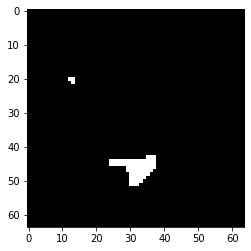

In [16]:
plt.imshow(mask_data[16, :, :], cmap='gray')

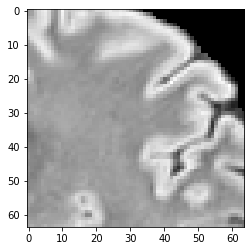

In [17]:
plt.imshow(img_data[16, :, :], cmap='gray')

In [22]:
def rescale_image(img_data):
    img_rescaled = img_data / 147
    a, b = [0.429, 0.833]
    img_rescaled = img_rescaled * (b-a) + a
    return img_rescaled

In [10]:
import torch
import sys
sys.path.append('LeFusion')

model_path = 'LeFusion/LeFusion_Model/MS_Patches_MemoryOptimized/model-61.pt'
checkpoint = torch.load(model_path, map_location='cpu')

print(f"Checkpoint step: {checkpoint['step']}")

from LeFusion.ddpm import Unet3D, GaussianDiffusion_Nolatent

model = Unet3D(
    dim=64,
    cond_dim=16,
    channels=1,
)

diffusion = GaussianDiffusion_Nolatent(
    model,
    image_size=64,
    num_frames=32,
    channels=1,
    timesteps=300,
    loss_type='l1',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    data_type='ms'
)

ema_state = checkpoint['ema']

corrected_state = {}
for key, value in ema_state.items():
    if key.startswith('denoise_fn.module.'):
        new_key = key.replace('denoise_fn.module.', 'denoise_fn.')
        corrected_state[new_key] = value
    else:
        corrected_state[key] = value

diffusion.load_state_dict(corrected_state)
diffusion.eval()

print("✅ Model loaded successfully!")

Checkpoint step: 6100
✅ Model loaded successfully!


In [18]:
from tqdm import tqdm

In [19]:
from omegaconf import DictConfig

class MSRepaintConfig:
    """
    Custom configuration class that mimics DictConfig but has .get() method.
    This ensures compatibility with the repaint sampling code.
    """
    
    def __init__(self, config_dict):
        # Store all configuration values
        for key, value in config_dict.items():
            setattr(self, key, value)
    
    def get(self, key, default=None):
        """
        Get method for compatibility with the repaint sampling code.
        """
        return getattr(self, key, default)
    
    def __getitem__(self, key):
        """
        Allow dictionary-style access.
        """
        return getattr(self, key)
    
    def __setitem__(self, key, value):
        """
        Allow dictionary-style assignment.
        """
        setattr(self, key, value)

def create_ms_repaint_config():
    """
    Create MS repaint configuration with proper .get() method support.
    """
    
    config_dict = {
        'data_type': 'ms',
        'cond_dim': 16,
        'types': 3,
        'diffusion_img_size': 64,
        'diffusion_depth_size': 32,
        'diffusion_num_channels': 1,
        'dim_mults': [1, 2, 4, 8],
        'batch_size': 1,
        
        'test_txt_dir': '',
        'dataset_root_dir': '',
        'target_img_path': '',
        'target_label_path': '',
        
        'load_milestone': False,
        'num_workers': 20,
        'save_and_sample_every': 1000,
        'denoising_fn': 'Unet3D',
        
        'train_lr': 1e-4,
        'timesteps': 300,
        'sampling_timesteps': 300,
        'loss_type': 'l1',
        'train_num_steps': 700000,
        'gradient_accumulate_every': 2,
        'ema_decay': 0.995,
        'amp': False,
        'num_sample_rows': 1,
        'gpus': 0,
        
        'attention_resolutions': '32,16,8',
        'class_cond': False,
        'diffusion_steps': 1000,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_heads': 4,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_fp16': False,
        'use_scale_shift_norm': True,
        'classifier_scale': 0,
        'lr_kernel_n_std': 2,
        'num_samples': 100,
        'show_progress': True,
        'timestep_respacing': '300',
        'use_kl': False,
        'predict_xstart': False,
        'rescale_timesteps': False,
        'rescale_learned_sigmas': False,
        'classifier_use_fp16': False,
        'classifier_width': 128,
        'classifier_depth': 2,
        'classifier_attention_resolutions': '32,16,8',
        'classifier_use_scale_shift_norm': True,
        'classifier_resblock_updown': True,
        'classifier_pool': 'attention',
        'num_heads_upsample': -1,
        'channel_mult': '',
        'dropout': 0.0,
        'use_checkpoint': False,
        'use_new_attention_order': False,
        'clip_denoised': True,
        'use_ddim': False,
        'latex_name': 'RePaint',
        'method_name': 'Repaint',
        'image_size': 256,
        'model_path': '',
        
        'name': 'ms_hist_3d',
        'inpa_inj_sched_prev': True,
        'n_jobs': 1,
        'print_estimated_vars': True,
        'inpa_inj_sched_prev_cumnoise': False,
        'inpa_inj_time_shift': 1,
        
        'schedule_jump_params': {
            't_T': 300,
            'n_sample': 1,
            'jump_length': 10,
            'jump_n_sample': 10
        }
    }
    
    return MSRepaintConfig(config_dict)

In [20]:
def ms_repaint_inference(diffusion, original_image, lesion_mask, hist_condition, 
                        conf=None, cond_scale=1.0, show_progress=True):
    """
    MS repaint inference using p_sample_loop_repaint (like LIDC/EMIDEC).
    This inpaints lesions into your original image using the mask.
    
    Args:
        diffusion: Trained GaussianDiffusion_Nolatent model
        original_image: Your original image tensor [1, 1, H, W, D]
        lesion_mask: Binary mask tensor [1, 1, H, W, D] where 1 = lesion region
        hist_condition: Histogram conditioning tensor [1, 16]
        conf: Configuration object (optional)
        cond_scale: Conditioning scale for guidance
        show_progress: Whether to show progress bar
    
    Returns:
        inpainted_image: Your image with inpainted lesion
    """
    
    device = original_image.device
    diffusion.to(device)
    diffusion.eval()
    
    with torch.no_grad():
        model_kwargs = {
            'gt': original_image,
            'gt_keep_mask': lesion_mask
        }
        
        batch_size = original_image.shape[0]
        
        sample_fn = diffusion.p_sample_loop_repaint
        
        shape = (1, 1, 32, 64, 64)
        
        print("Performing MS repaint inference...")
        
        output = sample_fn(
            shape=shape,
            model_kwargs=model_kwargs,
            device=device,
            progress=show_progress,
            conf=create_ms_repaint_config(),
            cond=hist_condition,
            cond_scale=cond_scale
        )
        
        return output

In [28]:
device = 'cuda'

In [29]:
hist_cond = torch.tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5600, 0.4400],
       device=device)

In [30]:
inpainted = ms_repaint_inference(
    diffusion=diffusion,
    original_image=torch.tensor(rescale_image(img_data)).to(device).float(),
    lesion_mask=torch.tensor(mask_data).to(device).float(),
    hist_condition=hist_cond,
    cond_scale=3.0
)

Performing MS repaint inference...


  0%|          | 0/5520 [00:00<?, ?it/s]

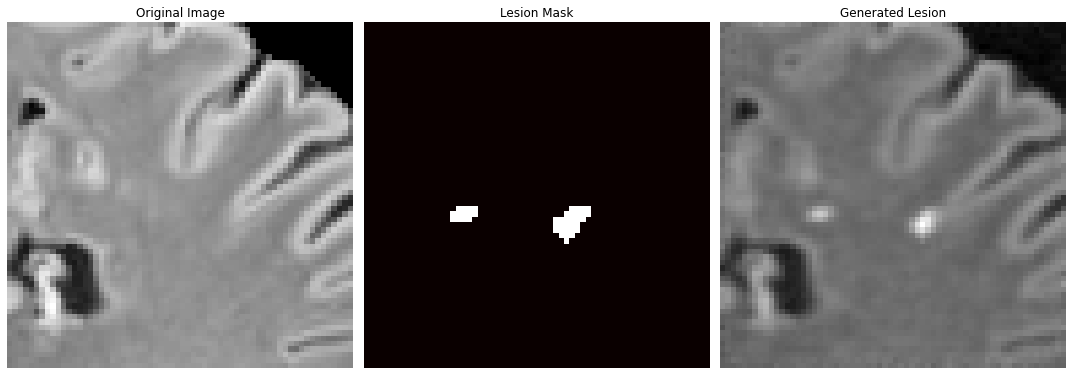

In [34]:
original = img_data[:, :, :]
mask_vis = mask_data[:, :, :]
generated_vis = inpainted[0, 0, :, :, :].cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

slice_idx = 5
axes[0].imshow(original[slice_idx, :, :], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mask_vis[slice_idx, :, :], cmap='hot')
axes[1].set_title('Lesion Mask')
axes[1].axis('off')

axes[2].imshow(generated_vis[slice_idx, :, :], cmap='gray')
axes[2].set_title('Generated Lesion')
axes[2].axis('off')
plt.tight_layout()